In [201]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from S00_utils import loadPickle, plot_res, store_results

In [202]:
df = pd.read_excel("output/S21__2025-04-21-052727.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__autocorrelation__lag_8,s1__autocorrelation__lag_9,s1__autocorrelation__lag_7,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,s1__autocorrelation__lag_4,s1__longest_strike_above_mean,...,s1__ar_coefficient__coeff_3__k_10,s1__approximate_entropy__m_2__r_0.1,s1__lempel_ziv_complexity__bins_3,s1__partial_autocorrelation__lag_4,"s1__fft_coefficient__attr_""abs""__coeff_7","s1__agg_autocorrelation__f_agg_""var""__maxlag_40",s1__spkt_welch_density__coeff_2,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,150.223716,1176.177278,1.142097,-0.305434,-0.519191,-0.074829,0.159896,0.385790,0.590387,14,...,0.183996,0.158567,0.204152,-0.360084,0.293617,0.499488,5.886812e-08,55.460434,1.065917,114.578620
E002,102.534268,1483.654982,1.104716,-0.243785,-0.454262,-0.021002,0.202836,0.416423,0.608972,14,...,0.184370,0.144742,0.203008,-0.344364,6.142373,0.477743,3.643621e-06,50.640306,1.285666,124.651484
E003,119.890549,1254.897451,2.162773,-0.329006,-0.543405,-0.095913,0.142612,0.373002,0.582151,14,...,0.184036,0.144268,0.208163,-0.364611,26.783283,0.506435,1.590028e-04,50.832405,1.154859,57.018054
E004,162.830799,1302.043195,1.308283,-0.065152,-0.266498,0.138913,0.337187,0.521401,0.683873,16,...,0.187213,0.137326,0.193662,-0.355441,33.227591,0.460547,7.926165e-04,62.476545,1.025161,132.221218
E005,165.720956,1154.482314,1.566830,-0.304881,-0.518177,-0.074836,0.159321,0.384728,0.589003,14,...,0.183978,0.128546,0.192440,-0.357588,11.439470,0.497940,1.462831e-04,57.634438,1.043776,92.160269


In [203]:
colsY = ["y1", "y2", "y3"]
# colsX = [c for c in df.columns if c not in colsY]
colsX = ["m1", "m2", "m3"]

dfX = df[colsX]
dfY = df[colsY]

In [204]:
dfData = loadPickle("output/S11__2025-04-21-052441.pickle")

In [205]:
dfData
tsArr = [t[1] for t in dfData["ts"].values]

In [206]:
# Max length
maxTime = 0
for ts in tsArr:
    maxTime = len(ts) if maxTime < len(ts) else maxTime

print(maxTime)

298


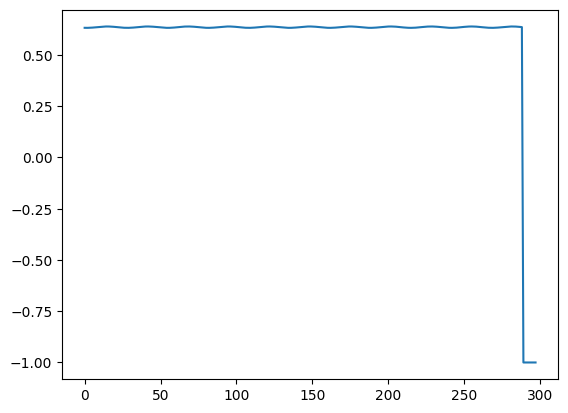

In [207]:
# Scaling and Padding
# TODO: Needs to only calculate mean, std, min, max from training example.

SCALING_TYPE = "Min_Max"
# SCALING_TYPE = "STANDARDIZATION"

tsArrConcat = np.concatenate(tsArr)
if SCALING_TYPE == "STANDARDIZATION":
    meanVal = np.mean(tsArrConcat)
    stdVal = np.std(tsArrConcat)
elif SCALING_TYPE == "Min_Max":
    maxVal = np.max(tsArrConcat)
    minVal = np.min(tsArrConcat)

# Shape = (Batch, Time, Features)
TsData_std = np.zeros((dfData.shape[0], maxTime, 1))
for idx, ts in enumerate(tsArr):
    if SCALING_TYPE == "STANDARDIZATION":
        ts_std = (ts - meanVal) / stdVal
    elif SCALING_TYPE == "Min_Max":
        ts_std = (ts - minVal) / (maxVal - minVal)

    TsData_std[idx, : len(ts), 0] = ts_std  # Scaling
    TsData_std[idx, len(ts) :, 0] = -1  # Padding

plt.plot(TsData_std[0, :])

In [208]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0, test_size=0.30)
idxs = np.arange(df.shape[0])
idxTrain, idxTest = next(cv.split(X=idxs))
print(idxTrain)
print(idxTest)

[60 80 90 68 51 27 18 56 63 74  1 61 42 41  4 15 17 40 38  5 91 59  0 34
 28 50 11 35 23 52 10 31 66 57 79 85 32 84 14 89 19 29 49 97 98 69 20 94
 72 77 25 37 81 46 39 65 58 12 88 70 87 36 21 83  9 96 67 64 47 44]
[26 86  2 55 75 93 16 73 54 95 53 92 78 13  7 30 22 24 33  8 43 62  3 71
 45 48  6 99 82 76]


In [209]:
dfX_train = dfX.iloc[idxTrain, :]
dfX_test = dfX.iloc[idxTest, :]
dfY_train = dfY.iloc[idxTrain, :]
dfY_test = dfY.iloc[idxTest, :]
Ts_train_std = TsData_std[idxTrain, :]
Ts_test_std = TsData_std[idxTest, :]

In [210]:
scX = MinMaxScaler()
X_train_std = scX.fit_transform(dfX_train)
X_test_std = scX.transform(dfX_test)

scY = MinMaxScaler()
Y_train_std = scY.fit_transform(dfY_train)
Y_test_std = scY.transform(dfY_test)

In [211]:
# Convert to 2D PyTorch tensors
X_train_std = torch.tensor(X_train_std, dtype=torch.float32)
Y_train_std = torch.tensor(Y_train_std, dtype=torch.float32)
X_test_std = torch.tensor(X_test_std, dtype=torch.float32)
Y_test_std = torch.tensor(Y_test_std, dtype=torch.float32)
Ts_train_std = torch.tensor(Ts_train_std, dtype=torch.float32)
Ts_test_std = torch.tensor(Ts_test_std, dtype=torch.float32)

In [212]:
import torch


class MyModel(nn.Module):
    def __init__(
        self,
        num_tabular_features,
        ts_embedding_size,
        num_ts_features,
        lstm_num_layers,
        lstm_dropout,
        attn_n_head,
        num_output,
    ):
        super().__init__()

        self.num_tabular_features = num_tabular_features
        self.num_ts_features = num_ts_features
        self.lstm_num_layers = lstm_num_layers
        self.lstm_dropout = lstm_dropout
        self.attn_n_head = attn_n_head
        self.num_output = num_output

        # Embeddeding layer (time series)
        self.ts_embedding_size = ts_embedding_size
        self.ts_embedders = nn.ModuleList(
            [nn.Linear(1, self.ts_embedding_size) for _ in range(self.num_ts_features)]
        )

        self.lstm = nn.LSTM(
            input_size=self.ts_embedding_size * self.num_ts_features,
            hidden_size=self.ts_embedding_size,  # This will be the output size
            num_layers=self.lstm_num_layers,
            batch_first=True,
            dropout=self.lstm_dropout,
        )

        self.emb_seeder = nn.Embedding(self.num_output, self.ts_embedding_size)

        self.imh_attn = InterpretableMultiHeadAttention(
            n_head=self.attn_n_head,
            d_model=self.ts_embedding_size,
            dropout=self.lstm_dropout,
        )

        # MLP to process each output
        self.mlps_ts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(ts_embedding_size, 64),
                    nn.ReLU(),
                    nn.Linear(64, 32),
                    nn.ReLU(),
                )
                for _ in range(0, num_output)
            ]
        )

        # MLP for tabular data
        self.mlp_tab = nn.Sequential(
            nn.Linear(num_tabular_features, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        self.regs = nn.ModuleList(
            [
                nn.Sequential(nn.Linear(64, 128), nn.ReLU(), nn.Linear(128, 1))
                for _ in range(0, num_output)
            ]
        )

    def forward(self, x_tab, x_ts, x_seeder):
        # x_tab: (batch, num_tabular_features)

        ts_out = torch.concat(
            [
                self.ts_embedders[i](x_ts[Ellipsis, i].unsqueeze(-1))
                for i in range(0, self.num_ts_features)
            ],
            axis=-1,
        )  # (batch, timestep, embedding_size * num_ts_features)

        ts_out, (hn, cn) = self.lstm(ts_out)  # (batch, timestep, embedding_size)

        seeder_out = self.emb_seeder(x_seeder)  # (batch, num_output, embeding_size )

        output = torch.concat([ts_out, seeder_out], axis=-2)
        output, attn = self.imh_attn(output, output, output)

        # Extract on the the last num_output features
        output = output[:, -self.num_output :, :]

        outs = []
        for i in range(0, self.num_output):
            out_tab = self.mlp_tab(x_tab)
            out_ts = self.mlps_ts[i](output[:, i, :])
            comb = torch.cat((out_tab, out_ts), dim=1)
            out = self.regs[i](comb)
            outs.append(out)

        final = torch.concat(outs, dim=1)

        return final, attn


class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0, scale=True):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.softmax = nn.Softmax(dim=2)
        self.scale = scale

    def forward(self, q, k, v, mask=None):
        # print('---Inputs----')
        # print('q: {}'.format(q[0]))
        # print('k: {}'.format(k[0]))
        # print('v: {}'.format(v[0]))

        attn = torch.bmm(q, k.permute(0, 2, 1))
        # print('first bmm')
        # print(attn.shape)
        # print('attn: {}'.format(attn[0]))

        if self.scale:
            dimention = torch.sqrt(torch.tensor(k.shape[-1]).to(torch.float32))
            attn = attn / dimention
        #    print('attn_scaled: {}'.format(attn[0]))

        if mask is not None:
            # fill = torch.tensor(-1e9).to(DEVICE)
            # zero = torch.tensor(0).to(DEVICE)
            attn = attn.masked_fill(mask == 0, -1e9)
        #    print('attn_masked: {}'.format(attn[0]))

        attn = self.softmax(attn)
        # print('attn_softmax: {}'.format(attn[0]))
        attn = self.dropout(attn)

        output = torch.bmm(attn, v)

        return output, attn


class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, dropout):
        super(InterpretableMultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = self.d_q = self.d_v = d_model // n_head
        self.dropout = nn.Dropout(p=dropout)

        self.v_layer = nn.Linear(self.d_model, self.d_v, bias=False)
        self.q_layers = nn.ModuleList(
            [nn.Linear(self.d_model, self.d_q, bias=False) for _ in range(self.n_head)]
        )
        self.k_layers = nn.ModuleList(
            [nn.Linear(self.d_model, self.d_k, bias=False) for _ in range(self.n_head)]
        )
        self.v_layers = nn.ModuleList([self.v_layer for _ in range(self.n_head)])
        self.attention = ScaledDotProductAttention()
        self.w_h = nn.Linear(self.d_v, self.d_model, bias=False)

        self.init_weights()

    def init_weights(self):
        for name, p in self.named_parameters():
            if "bias" not in name:
                torch.nn.init.xavier_uniform_(p)
            #                 torch.nn.init.kaiming_normal_(p, a=0, mode='fan_in', nonlinearity='sigmoid')
            else:
                torch.nn.init.zeros_(p)

    def forward(self, q, k, v, mask=None):
        heads = []
        attns = []
        for i in range(self.n_head):
            qs = self.q_layers[i](q)
            ks = self.k_layers[i](k)
            vs = self.v_layers[i](v)
            # print('qs layer: {}'.format(qs.shape))
            head, attn = self.attention(qs, ks, vs, mask)
            # print('head layer: {}'.format(head.shape))
            # print('attn layer: {}'.format(attn.shape))
            head_dropout = self.dropout(head)
            heads.append(head_dropout)
            attns.append(attn)

        head = torch.stack(heads, dim=2) if self.n_head > 1 else heads[0]
        # print('concat heads: {}'.format(head.shape))
        # print('heads {}: {}'.format(0, head[0,0,Ellipsis]))
        attn = torch.stack(attns, dim=2)
        # print('concat attn: {}'.format(attn.shape))

        outputs = torch.mean(head, dim=2) if self.n_head > 1 else head
        # print('outputs mean: {}'.format(outputs.shape))
        # print('outputs mean {}: {}'.format(0, outputs[0,0,Ellipsis]))
        outputs = self.w_h(outputs)
        outputs = self.dropout(outputs)

        return outputs, attn

In [213]:
num_tabular_features = dfX.shape[1]
ts_embedding_size = 16
num_ts_features = Ts_train_std.shape[-1]
lstm_num_layers = 2
lstm_dropout = 0.5
attn_n_head = 4
num_output = Y_test_std.shape[1]

# Initialize model
model = MyModel(
    num_tabular_features=num_tabular_features,
    ts_embedding_size=ts_embedding_size,
    num_ts_features=num_ts_features,
    lstm_num_layers=lstm_num_layers,
    lstm_dropout=lstm_dropout,
    attn_n_head=attn_n_head,
    num_output=num_output
)

In [214]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [215]:
def get_seeder(batch_size, num_output):
    x_seeder = torch.zeros((batch_size, num_output), dtype=torch.long)
    for i in range(0, num_output):
        x_seeder[:, i] = i    
    return x_seeder

MSE: 0.04
RMSE: 0.20


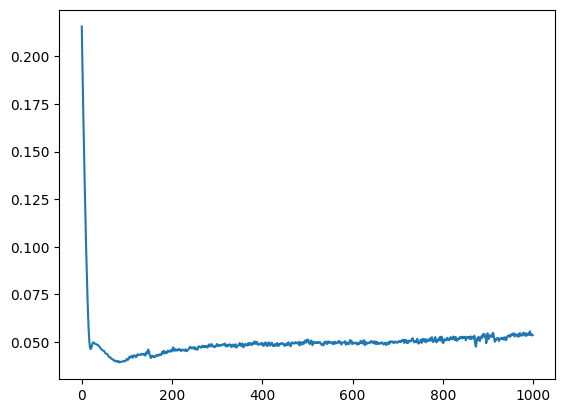

In [216]:
n_epochs = 1000
# number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train_std), batch_size)

# Hold the best model
best_mse = np.inf  # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            x_tab_batch = X_train_std[start : start + batch_size]
            x_ts_batch = Ts_train_std[start : start + batch_size]
            y_batch = Y_train_std[start : start + batch_size]
            # forward pass
            y_pred, _ = model(x_tab=x_tab_batch, x_ts=x_ts_batch, x_seeder=get_seeder(x_tab_batch.shape[0], num_output))
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()    
    y_pred, _ = model(x_ts=Ts_test_std, x_tab=X_test_std, x_seeder=get_seeder(Ts_test_std.shape[0], num_output))
    mse = loss_fn(y_pred, Y_test_std)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [217]:
Y_train_pred, attn_train = model(x_ts=Ts_train_std, x_tab=X_train_std, x_seeder=get_seeder(Ts_train_std.shape[0], num_output))
Y_test_pred, attn_test = model(x_ts=Ts_test_std, x_tab=X_test_std, x_seeder=get_seeder(Ts_test_std.shape[0], num_output))

In [218]:
Y_train_std = Y_train_std.detach().numpy()
Y_test_std = Y_test_std.detach().numpy()
Y_train_pred = Y_train_pred.detach().numpy()
Y_test_pred = Y_test_pred.detach().numpy()

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.038414,0.047866,0.142828,0.106892
1,0.026342,0.032591,0.314094,-0.054165
2,0.031976,0.036915,0.456154,0.295675


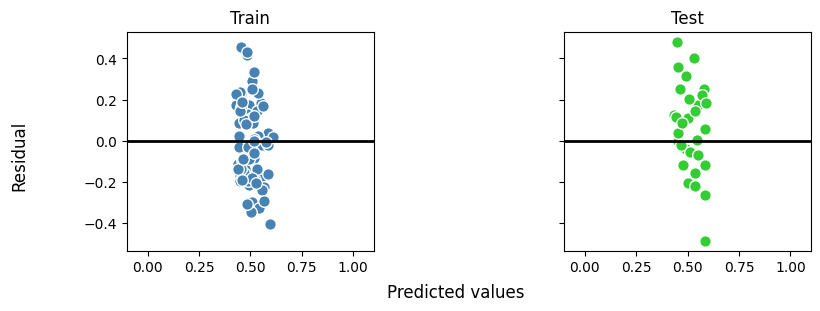

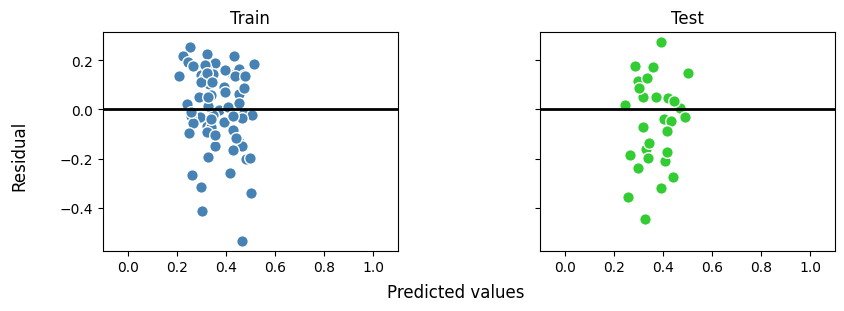

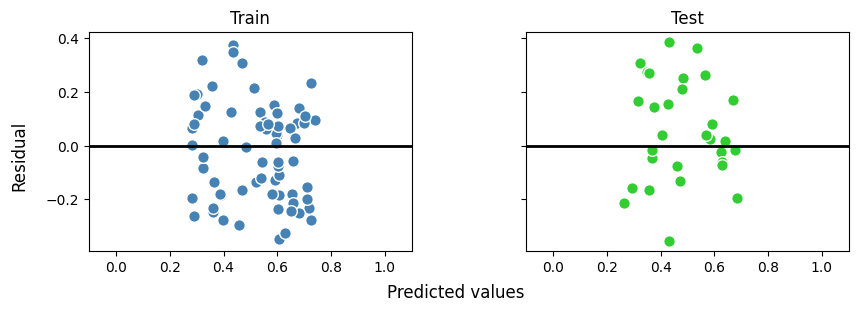

In [219]:
resArr = []
for i in range(dfY.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred, xlim=[-0.1, 1.1])
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes

In [220]:
attn_train.detach().numpy()[0, -1, 0, :]

array([0.00434536, 0.0039336 , 0.00368092, 0.00351708, 0.00340461,
       0.00332336, 0.00326188, 0.0032133 , 0.00317336, 0.00313937,
       0.0031097 , 0.00308342, 0.00306007, 0.00303949, 0.00302169,
       0.00300674, 0.00299476, 0.00298583, 0.00297998, 0.00297718,
       0.00297735, 0.00298031, 0.00298584, 0.00299361, 0.00300324,
       0.00301424, 0.00302609, 0.00303819, 0.0030499 , 0.0030606 ,
       0.00306968, 0.0030766 , 0.00308095, 0.00308243, 0.00308092,
       0.00307648, 0.00306932, 0.00305986, 0.0030486 , 0.00303618,
       0.00302325, 0.00301049, 0.00299852, 0.0029879 , 0.00297908,
       0.00297241, 0.00296816, 0.00296645, 0.00296734, 0.00297078,
       0.00297661, 0.00298461, 0.00299444, 0.00300569, 0.00301787,
       0.00303042, 0.00304273, 0.00305418, 0.00306416, 0.00307212,
       0.00307759, 0.00308025, 0.00307992, 0.00307659, 0.00307045,
       0.00306184, 0.00305124, 0.00303926, 0.00302654, 0.00301377,
       0.00300158, 0.00299056, 0.0029812 , 0.00297389, 0.00296